In [32]:
# Import library yang diperlukan
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import mediapipe as mp
from scipy.spatial import distance
import os
import random
import matplotlib.pyplot as plt

3. Load Gambar

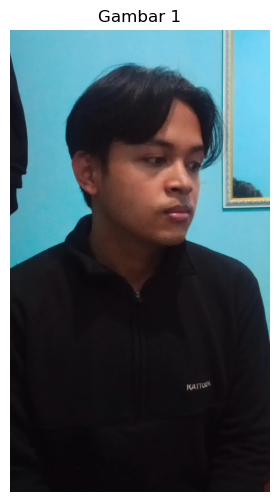

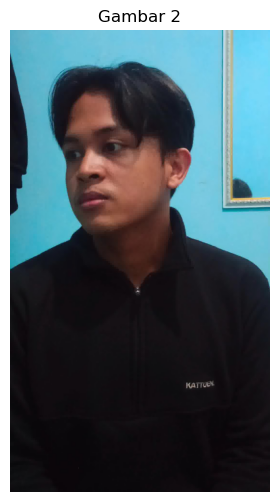

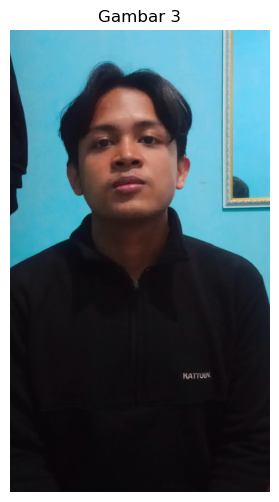

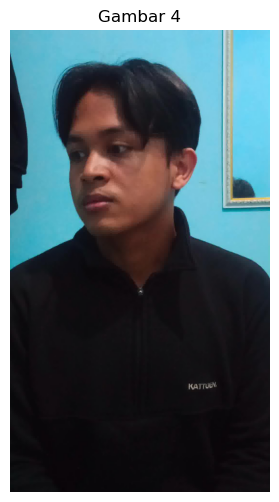

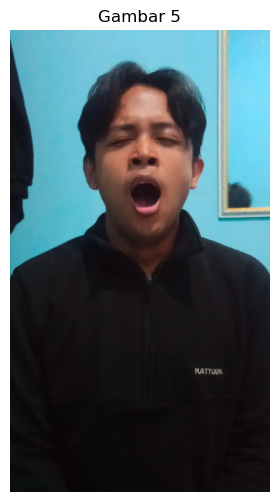

In [33]:

dataset_path = '/Kuliah/PBL/Dataset/'

# Mengumpulkan semua path gambar
image_paths = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

# Gunakan semua path gambar, atau jika ingin mengambil 10 gambar secara acak
random_image_paths = random.sample(image_paths, min(500, len(image_paths)))

# Memuat dan menampilkan setiap gambar menggunakan Matplotlib
for idx, image_path in enumerate(random_image_paths[:5]):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Gambar {idx + 1}")
    plt.show()


### 4.1. Pre-processing: BGR ke Grayscale, HOG Face Detector,

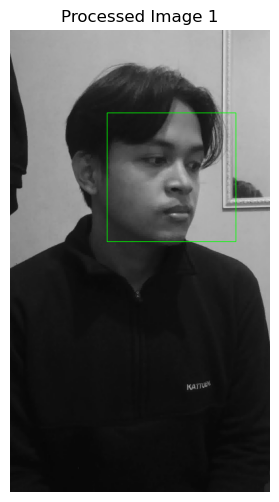

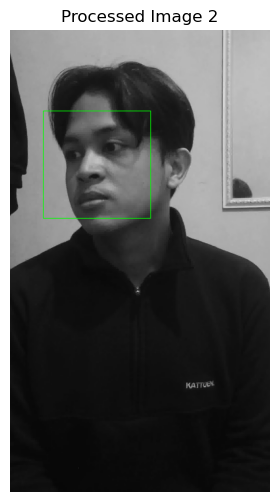

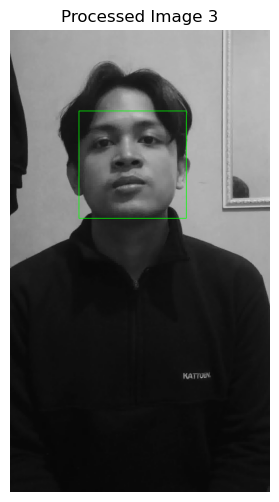

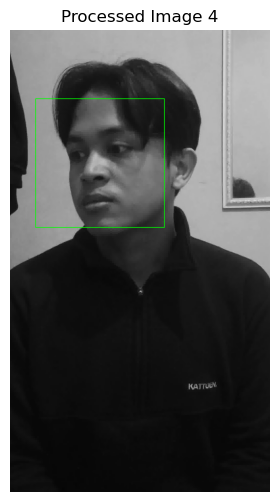

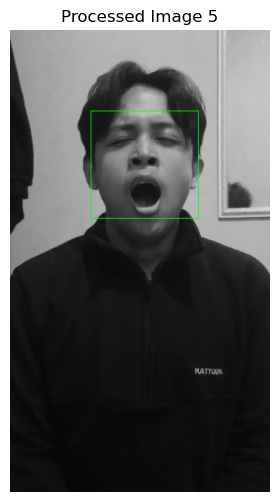

In [34]:
# Inisialisasi detektor wajah HOG
hog_face_detector = dlib.get_frontal_face_detector()

# List untuk menyimpan hasil pre-processing
processed_images = []  # Menyimpan gambar grayscale dengan kotak hijau

# Proses setiap gambar secara acak dari random_image_paths
for image_path in random_image_paths:  # Ganti dari os.walk ke random_image_paths
    # Baca gambar asli
    image = cv2.imread(image_path)

    # Konversi ke grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah pada gambar grayscale
    faces = hog_face_detector(gray)

    # Gambarkan kotak di sekitar wajah pada gambar grayscale
    image_with_faces = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  # Ubah grayscale ke BGR untuk menggambar kotak
    for face in faces:
        x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
        cv2.rectangle(image_with_faces, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Tambahkan hasil akhir ke list
    processed_images.append(image_with_faces)

    # Simpan hasil akhir ke file (opsional)
    # processed_image_path = image_path.replace('.jpg', '_processed.jpg').replace('.png', '_processed.png').replace('.jpeg', '_processed.jpeg')
    # cv2.imwrite(processed_image_path, image_with_faces)

    # Berhenti setelah memproses 5 gambar (contoh batasan)
    if len(processed_images) == 500:
        break

# Tampilkan hasil dari array processed_images (hanya 5 gambar pertama)
for i, img in enumerate(processed_images[:5]):  # Tambahkan slicing [:5] untuk membatasi
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Processed Image {i+1}')
    plt.axis('off')
    plt.show()


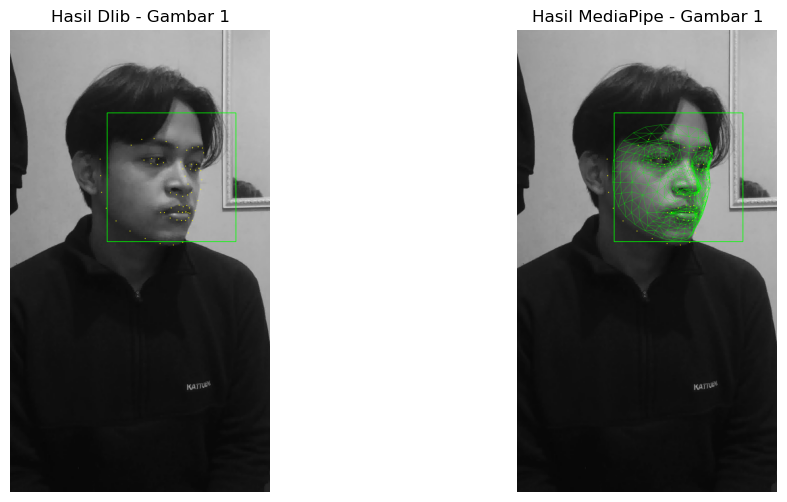

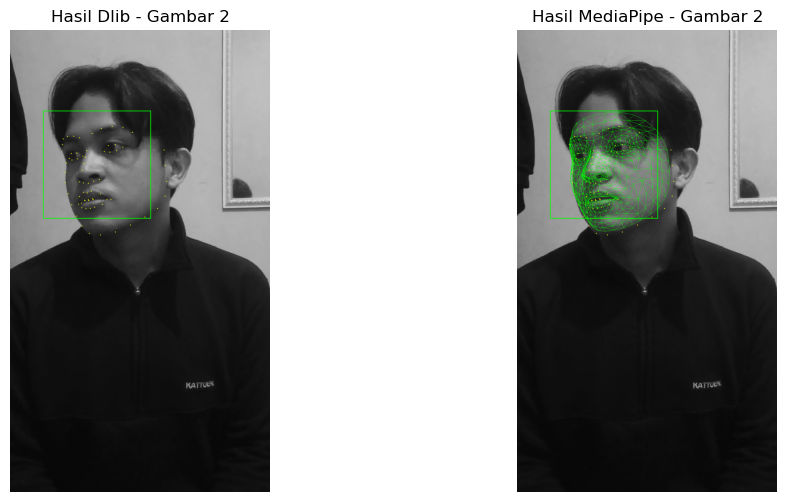

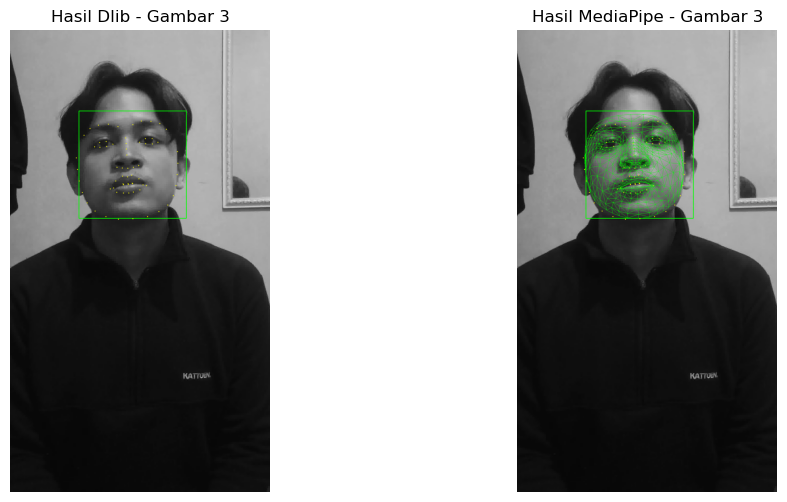

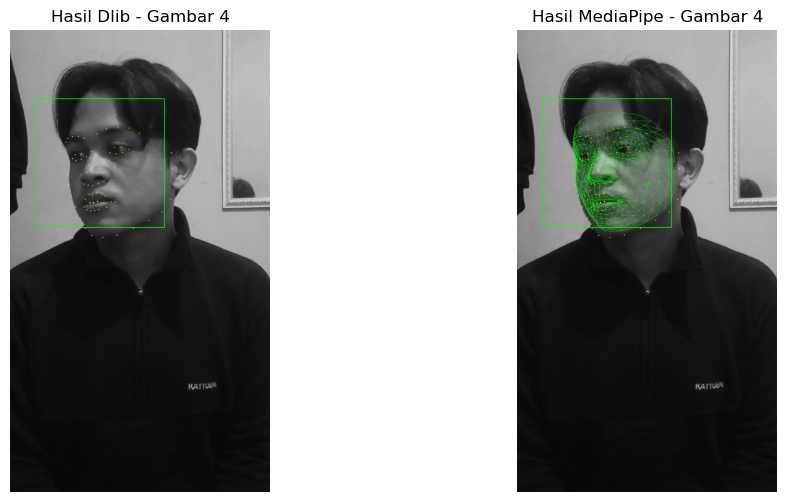

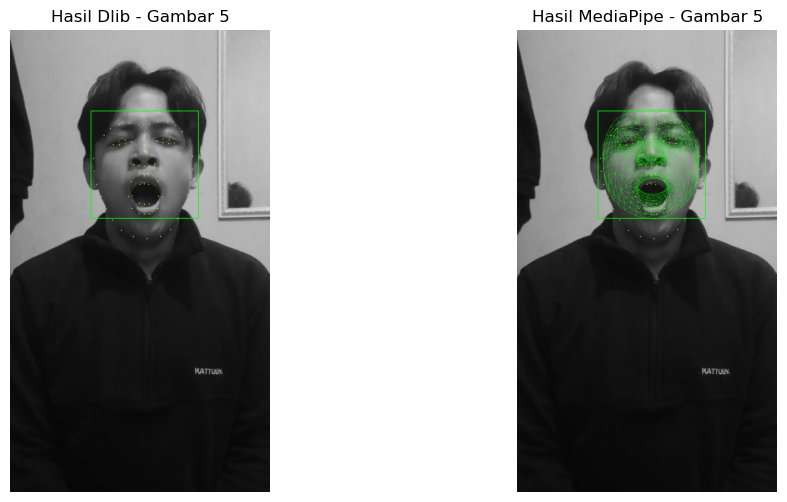

In [35]:
import cv2
import matplotlib.pyplot as plt
import dlib
import mediapipe as mp

# Memuat model Dlib untuk landmark wajah
predictor_path = '/Kuliah/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)
hog_face_detector = dlib.get_frontal_face_detector()  # Inisialisasi HOG face detector

# Inisialisasi MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    min_detection_confidence=0.5
)

# List untuk menyimpan hasil deteksi Dlib
dlib_processed_images = []
# List untuk menyimpan hasil deteksi MediaPipe
mediapipe_processed_images = []

# Proses setiap gambar dalam processed_images
for image in processed_images:  # Menggunakan gambar yang telah diproses sebelumnya
    # Konversi gambar ke grayscale untuk deteksi wajah dengan Dlib
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah dengan Dlib
    faces = hog_face_detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        for n in range(0, 68):  # Mengambil 68 titik landmark wajah
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image, (x, y), 2, (0, 255, 255), -1)  # Menandai titik landmark dengan warna kuning

    # Simpan gambar yang telah diproses oleh Dlib ke dalam list
    dlib_processed_images.append(image)

# Proses gambar-gambar yang telah diproses oleh Dlib dengan MediaPipe
for idx, image in enumerate(dlib_processed_images):
    # Gambar yang telah diproses Dlib digunakan sebagai input untuk MediaPipe
    image_mesh = image.copy()

    # Proses dengan Face Mesh dari MediaPipe
    results = face_mesh.process(cv2.cvtColor(image_mesh, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=image_mesh,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
            )

    # Simpan gambar hasil deteksi MediaPipe ke dalam list mediapipe_processed_images
    mediapipe_processed_images.append(image_mesh)

    # Menyimpan gambar hasil deteksi
    # dlib_result_path = f"result_dlib_{idx + 1}.jpg"
    # mediapipe_result_path = f"result_mediapipe_{idx + 1}.jpg"
    # cv2.imwrite(dlib_result_path, dlib_processed_images[idx])  # Simpan gambar hasil Dlib
    # cv2.imwrite(mediapipe_result_path, image_mesh)  # Simpan gambar hasil MediaPipe
for i, (dlib_image, mediapipe_image) in enumerate(zip(dlib_processed_images[:5], mediapipe_processed_images[:5])):
    plt.figure(figsize=(12, 6))

    # Plot hasil Dlib
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(dlib_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Hasil Dlib - Gambar {i + 1}')
    plt.axis('off')

    # Plot hasil MediaPipe
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(mediapipe_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Hasil MediaPipe - Gambar {i + 1}')
    plt.axis('off')

    plt.show()
    # # Menampilkan hasil dengan Matplotlib
    # plt.figure(figsize=(12, 6))

    # # Plot hasil Dlib
    # plt.subplot(1, 2, 1)
    # plt.imshow(cv2.cvtColor(dlib_processed_images[idx], cv2.COLOR_BGR2RGB))
    # plt.title(f'Hasil Dlib - Gambar {idx + 1}')
    # plt.axis('off')

    # # Plot hasil MediaPipe
    # plt.subplot(1, 2, 2)
    # plt.imshow(cv2.cvtColor(image_mesh, cv2.COLOR_BGR2RGB))
    # plt.title(f'Hasil MediaPipe - Gambar {idx + 1}')
    # plt.axis('off')

    # plt.show()

    # # Print nama gambar yang disimpan
    # print(f"Menampilkan dan menyimpan hasil gambar:")
    # print(f"  - Hasil Dlib disimpan sebagai: {dlib_result_path}")
    # print(f"  - Hasil MediaPipe disimpan sebagai: {mediapipe_result_path}")


In [36]:
# import cv2
# import dlib
# import mediapipe as mp
# import numpy as np
# from matplotlib import pyplot as plt

# # Path model Dlib
# predictor_path = '/Kuliah/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat'
# predictor = dlib.shape_predictor(predictor_path)
# hog_face_detector = dlib.get_frontal_face_detector()

# # Inisialisasi MediaPipe FaceMesh
# mp_face_mesh = mp.solutions.face_mesh
# mp_drawing = mp.solutions.drawing_utils
# face_mesh = mp_face_mesh.FaceMesh(
#     static_image_mode=True,
#     max_num_faces=1,
#     min_detection_confidence=0.5
# )

# # Daftar gambar yang akan diproses
# # Tambahkan gambar ke list ini
# processed_images = [cv2.imread("path/to/image.jpg")]  # Tambahkan lebih banyak gambar jika diperlukan

# # List untuk menyimpan fitur gabungan
# combined_features = []

# # Proses setiap gambar
# for idx, image in enumerate(processed_images):
#     # Ubah gambar ke grayscale untuk Dlib
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Deteksi wajah menggunakan Dlib
#     faces = hog_face_detector(gray)
#     if len(faces) > 0:  # Jika wajah terdeteksi
#         face = faces[0]  # Ambil wajah pertama
#         landmarks_dlib = predictor(gray, face)
#         dlib_landmarks = [(landmarks_dlib.part(n).x, landmarks_dlib.part(n).y) for n in range(68)]
#     else:
#         dlib_landmarks = []

#     # Deteksi wajah menggunakan MediaPipe
#     mediapipe_landmarks = []
#     results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     if results.multi_face_landmarks:
#         for face_landmarks in results.multi_face_landmarks:
#             # Ekstrak titik-titik landmark
#             for landmark in face_landmarks.landmark:
#                 mediapipe_landmarks.append((
#                     int(landmark.x * image.shape[1]),  # Koordinat X
#                     int(landmark.y * image.shape[0])   # Koordinat Y
#                 ))

#             # Gambar landmark di gambar asli
#             mp_drawing.draw_landmarks(
#                 image=image,
#                 landmark_list=face_landmarks,
#                 connections=mp_face_mesh.FACEMESH_TESSELATION,
#                 connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
#             )

#     # Gabungkan fitur
#     combined_features.append({
#         "Image Index": idx,
#         "Dlib Landmarks": dlib_landmarks,
#         "MediaPipe Landmarks": mediapipe_landmarks
#     })

#     # Visualisasi gabungan
#     image_combined = image.copy()

#     # Gambar landmark Dlib
#     for x, y in dlib_landmarks:
#         cv2.circle(image_combined, (x, y), 2, (0, 255, 255), -1)

#     # Gambar landmark MediaPipe
#     for x, y in mediapipe_landmarks:
#         cv2.circle(image_combined, (x, y), 2, (255, 0, 0), -1)

#     # Simpan hasil gabungan
#     combined_result_path = f"result_combined_{idx + 1}.jpg"
#     cv2.imwrite(combined_result_path, image_combined)

#     # Tampilkan hasil gabungan
#     plt.figure(figsize=(8, 8))
#     plt.imshow(cv2.cvtColor(image_combined, cv2.COLOR_BGR2RGB))
#     plt.title(f'Gabungan Landmark Dlib & MediaPipe - Gambar {idx + 1}')
#     plt.axis('off')
#     plt.show()

#     print(f"Hasil gabungan disimpan sebagai: {combined_result_path}")

# # Cetak sebagian fitur gabungan untuk verifikasi
# for feature in combined_features[:5]:
#     print(f"Gambar {feature['Image Index'] + 1}:")
#     print(f"  Landmark Dlib: {len(feature['Dlib Landmarks'])} titik")
#     print(f"  Landmark MediaPipe: {len(feature['MediaPipe Landmarks'])} titik")


# Ekstraksi Fitur

In [37]:
import numpy as np
from scipy.spatial import distance

# Fungsi untuk menghitung Eye Aspect Ratio (EAR)
def calculate_ear(landmarks):
    # Menghitung jarak antara titik-titik pada mata
    # Mata Kiri
    A1 = distance.euclidean(np.array(landmarks[37]), np.array(landmarks[41]))  # Vertikal
    B1 = distance.euclidean(np.array(landmarks[38]), np.array(landmarks[40]))  # Vertikal
    C1 = distance.euclidean(np.array(landmarks[36]), np.array(landmarks[39]))  # Horizontal

    # Mata Kanan
    A2 = distance.euclidean(np.array(landmarks[43]), np.array(landmarks[47]))  # Vertikal
    B2 = distance.euclidean(np.array(landmarks[44]), np.array(landmarks[46]))  # Vertikal
    C2 = distance.euclidean(np.array(landmarks[42]), np.array(landmarks[45]))  # Horizontal

    # Menghitung EAR untuk kedua mata dan rata-ratanya
    ear_left = (B1 + C1) / (2.0 * A1)
    ear_right = (B2 + C2) / (2.0 * A2)

    ear = (ear_left + ear_right) / 2.0
    return ear

# Fungsi untuk menghitung Mouth Aspect Ratio (MAR)
def calculate_mar(landmarks):
    # Menghitung jarak antara titik-titik pada mulut
    A = distance.euclidean(np.array(landmarks[62]), np.array(landmarks[66]))  # Jarak vertikal
    B = distance.euclidean(np.array(landmarks[61]), np.array(landmarks[67]))  # Jarak horizontal
    C = distance.euclidean(np.array(landmarks[60]), np.array(landmarks[64]))  # Jarak horizontal
    D = distance.euclidean(np.array(landmarks[59]), np.array(landmarks[63]))  # Jarak horizontal

    # Menghitung MAR menggunakan formula
    mar = (B + C + D) / (2.0 * A)
    return mar


In [38]:
# Daftar untuk menyimpan hasil per gambar
results = []

# Proses setiap gambar dari list hasil MediaPipe
for idx, image in enumerate(mediapipe_processed_images):  # Gambar sudah dalam bentuk array, tidak perlu membaca dengan cv2.imread
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = hog_face_detector(gray)

    # List untuk menyimpan data per wajah
    ear_values = []
    mar_values = []
    nose_x_coords = []
    nose_y_coords = []

    for face in faces:  # Loop untuk setiap wajah yang terdeteksi
        landmarks = predictor(gray, face)  # Dapatkan landmark wajah

        # Ubah objek landmark dlib menjadi list koordinat (x, y)
        landmarks_list = [(p.x, p.y) for p in landmarks.parts()]

        # Hitung EAR dan MAR
        ear = calculate_ear(landmarks_list)
        mar = calculate_mar(landmarks_list)

        # Tambahkan nilai EAR dan MAR ke list
        ear_values.append(ear)
        mar_values.append(mar)

        # Ekstrak koordinat x dan y untuk landmark hidung (landmark 30)
        nose_x = landmarks.part(30).x
        nose_y = landmarks.part(30).y

        # Tambahkan koordinat ke list
        nose_x_coords.append(nose_x)
        nose_y_coords.append(nose_y)

    # Simpan hasil untuk gambar saat ini ke dalam dictionary
    results.append({
        "Gambar": idx + 1,
        "EAR": ear_values,
        "MAR": mar_values,
        "Nose X": nose_x_coords,
        "Nose Y": nose_y_coords,
    })

# Cetak hasil per gambar
for result in results:
    print(f"Gambar {result['Gambar']}:")
    print("  Eye Aspect Ratios:", result["EAR"])
    print("  Mouth Aspect Ratios:", result["MAR"])
    print("  Nose X Coordinates:", result["Nose X"])
    print("  Nose Y Coordinates:", result["Nose Y"])

# Cetak hasil akhir untuk semua gambar
print("Hasil Akhir:")
for result in results:
    print(f"Gambar {result['Gambar']}: {result}")


C:\Users\User\AppData\Local\Temp\ipykernel_16456\1072542112.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  mar = (B + C + D) / (2.0 * A)


Gambar 1:
  Eye Aspect Ratios: [1.8437803164446587]
  Mouth Aspect Ratios: [15.610672340198022]
  Nose X Coordinates: [727]
  Nose Y Coordinates: [627]
Gambar 2:
  Eye Aspect Ratios: [1.810895616818351]
  Mouth Aspect Ratios: [5.498902731114504]
  Nose X Coordinates: [296]
  Nose Y Coordinates: [583]
Gambar 3:
  Eye Aspect Ratios: [2.2539656283506444]
  Mouth Aspect Ratios: [13.249729953619882]
  Nose X Coordinates: [486]
  Nose Y Coordinates: [520]
Gambar 4:
  Eye Aspect Ratios: [1.9042687731667804]
  Mouth Aspect Ratios: [3.804835825011194]
  Nose X Coordinates: [319]
  Nose Y Coordinates: [582]
Gambar 5:
  Eye Aspect Ratios: [2.555757079188198]
  Mouth Aspect Ratios: [2.1157306861881473]
  Nose X Coordinates: [551]
  Nose Y Coordinates: [501]
Gambar 6:
  Eye Aspect Ratios: [1.9596989442665667]
  Mouth Aspect Ratios: [15.935744713231403]
  Nose X Coordinates: [368]
  Nose Y Coordinates: [527]
Gambar 7:
  Eye Aspect Ratios: [2.647410501866604]
  Mouth Aspect Ratios: [11.00096799572888

In [39]:
# # Threshold untuk menentukan kondisi aman atau tidak
# EAR_THRESHOLD = 2.5  # Tentukan ambang batas sesuai data
# MAR_THRESHOLD = 1.2  # Tentukan ambang batas sesuai data

# # List untuk menyimpan hasil target (1 = safe, 0 = unsafe)
# safe_drive_targets = []

# # Logika untuk menentukan target berdasarkan EAR dan MAR
# for ear, mar in zip(ear_values, mar_values):
#     if ear < EAR_THRESHOLD or mar > MAR_THRESHOLD:
#         safe_drive_targets.append(0)  # Unsafe
#     else:
#         safe_drive_targets.append(1)  # Safe

# # Menampilkan hasil akhir
# print("Hasil Akhir:")
# print("Eye Aspect Ratios:", ear_values)
# print("Mouth Aspect Ratios:", mar_values)
# print("Nose X Coordinates:", nose_x_coords)
# print("Nose Y Coordinates:", nose_y_coords)
# print("Safe Drive Targets:", safe_drive_targets)


In [ ]:
import csv
import json

# Daftar untuk menyimpan hasil per gambar
results = []

# Proses setiap gambar dari list hasil MediaPipe
for idx, image in enumerate(mediapipe_processed_images):  # Gambar sudah dalam bentuk array, tidak perlu membaca dengan cv2.imread
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = hog_face_detector(gray)

    # List untuk menyimpan data per wajah
    ear_values = []
    mar_values = []
    nose_x_coords = []
    nose_y_coords = []
    labels = []  # Untuk menyimpan label "ngantuk" atau "tidak ngantuk"

    for face in faces:  # Loop untuk setiap wajah yang terdeteksi
        landmarks = predictor(gray, face)  # Dapatkan landmark wajah

        # Ubah objek landmark dlib menjadi list koordinat (x, y)
        landmarks_list = [(p.x, p.y) for p in landmarks.parts()]

        # Hitung EAR dan MAR
        ear = calculate_ear(landmarks_list)
        mar = calculate_mar(landmarks_list)

        # Tentukan label berdasarkan EAR dan MAR
        if ear < 2.1:
            ear_label = "ngantuk"
        else:
            ear_label = "tidak ngantuk"

        if mar >= 2.3:
            mar_label = "ngantuk"
        else:
            mar_label = "tidak ngantuk"

        # Kombinasikan label EAR dan MAR
        label = "ngantuk" if (ear_label == "ngantuk" or mar_label == "ngantuk") else "tidak ngantuk"

        # Tambahkan nilai EAR, MAR, koordinat hidung, dan label ke list
        ear_values.append(ear)
        mar_values.append(mar)
        nose_x_coords.append(landmarks.part(30).x)
        nose_y_coords.append(landmarks.part(30).y)
        labels.append(label)

    # Simpan hasil untuk gambar saat ini ke dalam dictionary
    results.append({
        "Gambar": idx + 1,
        "EAR": ear_values,
        "MAR": mar_values,
        "Nose X": nose_x_coords,
        "Nose Y": nose_y_coords,
        "Label": labels  # Menyimpan label ngantuk/tidak ngantuk
    })

# Menyimpan hasil ekstraksi fitur ke dalam file CSV
csv_file_path = 'ekstraksi_fitur_label.csv'

header = ['Gambar', 'EAR', 'MAR', 'Nose X', 'Nose Y', 'Label']  # Menambahkan kolom label

# Menulis data ke file CSV
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)  # Menulis header
    
    for result in results:
        for ear, mar, nose_x, nose_y, label in zip(result['EAR'], result['MAR'], result['Nose X'], result['Nose Y'], result['Label']):
            writer.writerow([result['Gambar'], ear, mar, nose_x, nose_y, label])

print(f"Hasil berhasil disimpan dalam {csv_file_path}")

# Menyimpan hasil ekstraksi fitur ke dalam file JSON
json_file_path = 'ekstraksi_fitur_label.json'

data_to_save = []

for result in results:
    for ear, mar, nose_x, nose_y, label in zip(result['EAR'], result['MAR'], result['Nose X'], result['Nose Y'], result['Label']):
        data_to_save.append({
            "Gambar": result['Gambar'],
            "EAR": ear,
            "MAR": mar,
            "Nose X": nose_x,
            "Nose Y": nose_y,
            "Label": label  # Menyimpan label ngantuk/tidak ngantuk
        })

with open(json_file_path, mode='w') as file:
    json.dump(data_to_save, file, indent=4)

print(f"Hasil berhasil disimpan dalam {json_file_path}")


C:\Users\User\AppData\Local\Temp\ipykernel_16456\1072542112.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  mar = (B + C + D) / (2.0 * A)


Hasil berhasil disimpan dalam ekstraksi_fitur_label.csv
Hasil berhasil disimpan dalam ekstraksi_fitur_label.json


In [41]:
# import pandas as pd

# # Buat DataFrame dari data yang sudah diolah
# data = {
#     "Eye Aspect Ratios": ear_values,
#     "Mouth Aspect Ratios": mar_values,
#     "Nose X Coordinates": nose_x_coords,
#     "Nose Y Coordinates": nose_y_coords,
#     "Safe Drive Targets": safe_drive_targets
# }
# df = pd.DataFrame(data)

# # Simpan ke file CSV
# csv_file_path = "safe_drive_data.csv"
# df.to_csv(csv_file_path, index=False)
# print(f"Data berhasil disimpan ke {csv_file_path}")


C:\Users\User\AppData\Local\Temp\ipykernel_16456\1072542112.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  mar = (B + C + D) / (2.0 * A)


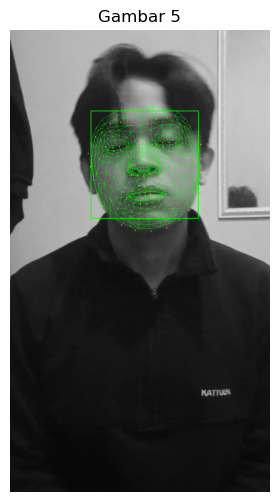


Hasil Ekstraksi Fitur untuk Gambar 5:
  Eye Aspect Ratios (EAR): [2.7243589157450665]
  Mouth Aspect Ratios (MAR): [53.3255912558559]
  Nose X Coordinates: [547]
  Nose Y Coordinates: [550]


In [58]:
import matplotlib.pyplot as plt
import cv2

# Daftar untuk menyimpan hasil per gambar
results = []

# Proses setiap gambar dari list hasil MediaPipe
for idx, image in enumerate(mediapipe_processed_images):  # Gambar sudah dalam bentuk array, tidak perlu membaca dengan cv2.imread
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah
    faces = hog_face_detector(gray)

    # List untuk menyimpan data per wajah
    ear_values = []
    mar_values = []
    nose_x_coords = []
    nose_y_coords = []

    for face in faces:  # Loop untuk setiap wajah yang terdeteksi
        landmarks = predictor(gray, face)  # Dapatkan landmark wajah

        # Ubah objek landmark dlib menjadi list koordinat (x, y)
        landmarks_list = [(p.x, p.y) for p in landmarks.parts()]

        # Hitung EAR dan MAR
        ear = calculate_ear(landmarks_list)
        mar = calculate_mar(landmarks_list)

        # Tambahkan nilai EAR dan MAR ke list
        ear_values.append(ear)
        mar_values.append(mar)

        # Ekstrak koordinat x dan y untuk landmark hidung (landmark 30)
        nose_x = landmarks.part(30).x
        nose_y = landmarks.part(30).y

        # Tambahkan koordinat ke list
        nose_x_coords.append(nose_x)
        nose_y_coords.append(nose_y)

    # Simpan hasil untuk gambar saat ini ke dalam dictionary
    results.append({
        "Gambar": idx + 1,
        "EAR": ear_values,
        "MAR": mar_values,
        "Nose X": nose_x_coords,
        "Nose Y": nose_y_coords,
    })

# Tampilkan gambar kelima dan hasil ekstraksi fitur dari gambar kelima
if len(mediapipe_processed_images) >= 10:  # Pastikan ada setidaknya 5 gambar
    # Menampilkan gambar kelima
    fifth_image = mediapipe_processed_images[8]  # Gambar kelima (index 4)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(fifth_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Gambar 5")
    plt.axis('off')
    plt.show()

    # Menampilkan hasil ekstraksi fitur gambar kelima
    fifth_result = results[8]  # Hasil dari gambar kelima
    print(f"\nHasil Ekstraksi Fitur untuk Gambar 5:")
    print(f"  Eye Aspect Ratios (EAR): {fifth_result['EAR']}")
    print(f"  Mouth Aspect Ratios (MAR): {fifth_result['MAR']}")
    print(f"  Nose X Coordinates: {fifth_result['Nose X']}")
    print(f"  Nose Y Coordinates: {fifth_result['Nose Y']}")
else:
    print("Terdapat kurang dari 5 gambar dalam daftar.")


# Model Random Forest

Memuat dan Menyiapkan data

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import joblib


In [43]:
import pandas as pd

# Membaca data dari file CSV
df = pd.read_csv('/Kuliah/PBL/ekstraksi_fitur_label.csv')

# Memisahkan fitur dan label
X = df[['EAR', 'MAR', 'Nose X', 'Nose Y']]  # Fitur
y = df['Label']  # Label


Konversi Label ke Angka untuk Random Forest

In [44]:
from sklearn.preprocessing import LabelEncoder

# Mengonversi label menjadi angka
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Mengubah label ke angka


Split Data

In [76]:
from sklearn.model_selection import train_test_split

# Membagi data menjadi data latih dan data uji (80% latih, 20% uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Latih Model

In [77]:
import pandas as pd
import numpy as np

# Deteksi baris dan kolom dengan nilai inf
inf_indices = np.where(np.isinf(X_train.values))
print("Indeks baris dengan inf:", inf_indices[0])
print("Indeks kolom dengan inf:", inf_indices[1])

# Menampilkan nilai inf di DataFrame
for row, col in zip(inf_indices[0], inf_indices[1]):
    print(f"Nilai inf di baris {row}, kolom {X_train.columns[col]}:", X_train.iloc[row, col])


Indeks baris dengan inf: [226 265 306 311 323 381]
Indeks kolom dengan inf: [1 1 1 1 1 1]
Nilai inf di baris 226, kolom MAR: inf
Nilai inf di baris 265, kolom MAR: inf
Nilai inf di baris 306, kolom MAR: inf
Nilai inf di baris 311, kolom MAR: inf
Nilai inf di baris 323, kolom MAR: inf
Nilai inf di baris 381, kolom MAR: inf


In [78]:
for col in X_train.columns:
    if np.isinf(X_train[col].values).any():
        col_mean = X_train[~np.isinf(X_train[col])][col].mean()
        X_train[col].replace([np.inf, -np.inf], col_mean, inplace=True)


C:\Users\User\AppData\Local\Temp\ipykernel_16456\2302598254.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].replace([np.inf, -np.inf], col_mean, inplace=True)


In [ ]:
# Membuat dan melatih model Random Forest
from sklearn.ensemble import RandomForestClassifier

# Buat model Random Forest dengan pembatasan hyperparameter
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
model.fit(X_train, y_train)



RandomForestClassifier(max_depth=20, min_samples_split=20, n_estimators=200,
                       random_state=42)

Evaluasi Model

In [1]:
# Memprediksi hasil pada data latih
y_pred_train = model.predict(X_train)

# Evaluasi model pada data latih
print("\nEvaluasi pada Data Latih (Training Data):")
print(f"Akurasi pada Data Latih: {accuracy_score(y_train, y_pred_train)}")
print(classification_report(y_train, y_pred_train))

NameError: name 'model' is not defined

In [86]:

# Memprediksi hasil pada data latih
y_pred_train = model.predict(X_train)

# Evaluasi model pada data latih
print("\nEvaluasi pada Data Latih (Training Data):")
print(f"Akurasi pada Data Latih: {accuracy_score(y_train, y_pred_train)}")
print(classification_report(y_train, y_pred_train))

# Memprediksi hasil pada data uji
y_pred = model.predict(X_test)

# Evaluasi model pada data uji
print(f'Akurasi pada Data Uji: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))



Evaluasi pada Data Latih (Training Data):
Akurasi pada Data Latih: 0.9948320413436692
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       240
           1       1.00      0.99      0.99       147

    accuracy                           0.99       387
   macro avg       1.00      0.99      0.99       387
weighted avg       0.99      0.99      0.99       387

Akurasi pada Data Uji: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        36

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97



Simpan Model

In [51]:
import joblib

# Simpan model ke file
joblib.dump(model, 'model_random_forest.pkl')
print("Model berhasil disimpan ke file 'model_random_forest.pkl'")


Model berhasil disimpan ke file 'model_random_forest.pkl'


In [52]:
print(model)  # Jika model sudah didefinisikan, outputnya akan menampilkan informasi model


RandomForestClassifier(max_depth=10, min_samples_split=10, random_state=42)
